In [11]:
import numpy as np

import torch
import torch.utils.data as data
from torch.autograd.variable import Variable

from imageio import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
import os
import pickle

from pycocotools.coco import COCO
%matplotlib inline 

# Data location

In [13]:
MAIN_FOLDER = "/Volumes/TOSHIBA EXT/data/"
IMAGES_FOLDER = os.path.join(MAIN_FOLDER, "train2017")
IMAGES_FOLDER_TEST = os.path.join(MAIN_FOLDER, "val2017")
ANNOTATION_FILE = os.path.join(MAIN_FOLDER, "annotations/person_keypoints_train2017.json")
ANNOTATION_FILE_TEST = os.path.join(MAIN_FOLDER, "annotations/person_keypoints_val2017.json")
CHECKPOINTS_FOLDER = "./cktp/"

# 1. Dataset exploration

## Images

/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


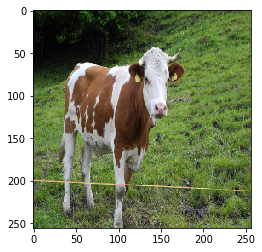

In [3]:
# Homemade image loader
def load_image(image_path):
    image = imread(image_path)
    image = resize(image, (256, 256))
    return image

img = load_image(os.path.join(IMAGES_FOLDER, "000000208459.jpg"))
plt.imshow(img)

## Annotations and COCO api

### COCO api

### Keypoints annotations example

In [30]:
# Load COCO api instance
coco = COCO(ANNOTATION_FILE)
# Get the image ids
imgIds = coco.getImgIds();

loading annotations into memory...
Done (t=34.43s)
creating index...
index created!


#### Example image

In [5]:
# Get an example image
img_id = imgIds[800]
img = coco.loadImgs(img_id)[0]
print('Image id :{}\n'.format(img_id))
print('Image information from the API:\n{}\n'.format(img))

# Local path to avoid downloading data
img_path = os.path.join(IMAGES_FOLDER, img['file_name'])
print('Local image path :\n{}\n'.format(img_path))

Image id :284220

Image information from the API:
{'license': 3, 'file_name': '000000284220.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000284220.jpg', 'height': 512, 'width': 640, 'date_captured': '2013-11-23 04:30:15', 'flickr_url': 'http://farm3.staticflickr.com/2312/2330494156_51691c6eb7_z.jpg', 'id': 284220}

Local image path :
/Volumes/TOSHIBA EXT/data/train2017/000000284220.jpg



#### Annotations for this image

In [32]:
# Get the annotation ids
ann_ids = coco.getAnnIds(imgIds=img['id'])

# Load the corresponding annotation
anns = coco.loadAnns(ann_ids)
anno = anns[0]
print('Annotations:\n{}\n'.format(anno))

# Get the keypoints
keypoints = anno['keypoints']
print('Keypoints:\n{}\n'.format(keypoints))

Annotations:
{'segmentation': [[352.55, 146.82, 353.61, 137.66, 356.07, 112.66, 357.13, 94.7, 357.13, 84.49, 363.12, 73.92, 370.16, 68.64, 370.16, 66.53, 368.4, 63.71, 368.05, 54.56, 361, 53.85, 356.07, 50.33, 356.43, 46.46, 364.17, 42.23, 369.1, 35.89, 371.22, 30.96, 376.85, 26.39, 383.54, 22.16, 391.29, 23.22, 400.79, 27.79, 402.2, 30.61, 404.32, 34.84, 406.08, 38.71, 406.08, 41.53, 406.08, 47.87, 407.84, 54.91, 408.89, 59.84, 408.89, 61.25, 408.89, 63.36, 422.28, 67.94, 432.13, 72.52, 445.87, 81.32, 446.57, 84.14, 446.57, 99.2, 451.15, 118.22, 453.26, 128.39, 453.61, 131.92, 453.61, 133.68, 451.5, 137.55, 451.5, 139.31, 455.38, 144.24, 455.38, 153.04, 455.73, 155.16, 461.01, 162.85, 462.07, 166.37, 459.95, 170.6, 459.6, 176.58, 459.95, 178.69, 459.95, 180.1, 448.33, 180.45, 447.98, 177.64, 446.57, 172.36, 447.63, 166.37, 449.74, 160.38, 450.09, 157.57, 448.68, 152.28, 445.16, 147.71, 441.29, 143.48, 435.66, 142.78, 428.26, 141.37, 420.87, 141.37, 418.75, 141.37, 411.71, 144.19, 404.

#### Display the example

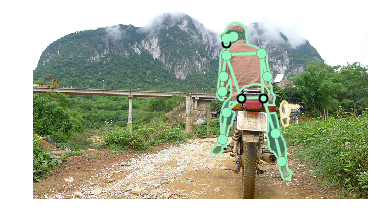

In [33]:
# Read the image from the path
I = imread(img_path)
# Plot the image
plt.imshow(I); plt.axis('off')

# Display the annotation
coco.showAnns(anns)
plt.show()

# 2. Data loaders for Pytorch

## 2.1 Transform keypoints into heatmaps

### 2.1.1 Gaussian heatmap generation

#### Function

In [4]:
def gaussian_heatmap(shape, keypoint_coordinates, std = 1.5):
    """
        Computes a square gaussian kernel

        :param shape: Shape of the output heatmap
        :param keypoint_coordinates: Location of the keypoint
        :param std: Standard deviation

        :return: Heatmap of shape (1,shape,shape)
    """
    
    # Get the coordinates
    x = keypoint_coordinates[0]
    y = keypoint_coordinates[1]
    
    a = np.arange(0, shape, 1, float)
    b = a[:,np.newaxis]

    # Generate the heatmap
    heatmap_raw = np.exp(-(((a-x)**2)/(2*std**2) + ((b-y)**2)/(2*std**2)))
    
    # Normalize
    heatmap_max = np.amax(heatmap_raw)
    heatmap_normalized = heatmap_raw/heatmap_max
    
    # Get it in the accurate format
    heatmap = np.expand_dims(heatmap_raw, axis=0)
    return heatmap

In [5]:
def keypoints_from_heatmap(heatmap):
    """Get the coordinates of the max value heatmap - it is the keypoint"""
    max_heatmap = np.amax(heatmap)
    keypoints = np.where(heatmap == max_heatmap)
    if len(keypoints) == 2:
        return keypoints[1][0], keypoints[0][0], max_heatmap
        
    elif len(keypoints) == 3:
        return keypoints[2][0], keypoints[1][0], max_heatmap

#### Example

In [7]:
heatmap = gaussian_heatmap(100, (25, 29))
plt.figure()
plt.title('Gaussian heatmap example')
# Here we use heatmap[0] instead of heatmap because of matplotlib format conventions
plt.imshow(heatmap[0])
print(keypoints_from_heatmap(heatmap))

(25, 29, 1.0)


In [6]:
def gaussian_heatmaps(xs, ys, vs, shape=32, image_height=512, image_width=640, std=1.):
    """
        Computes heatmaps from the keypoints
        :param xs: Array of x coordinates for the keypoints
        :param ys: Array of y coordinates for the keypoints
        :param shape: shape of the heatmaps
        :param image_height: Height of the images the keypoints are for
        :param image_width: Width of the images the keypoints are for
        :param std: Standard deviation of the gaussion function used
        
        :return: Heatmaps as numpy arrays of shape (shape, shape, n_keypoints)
    """
    
    # Rescale keypoints coordinates to the heatmaps scale
    # ys
    height_scale = shape/image_height
    ys = ys*height_scale
    # xs
    width_scale = shape/image_width
    xs = xs*width_scale
    
    
    # Render a heatmap for each joint
    heatmaps = gaussian_heatmap(shape, (xs[0],ys[0]))
    for i, v in enumerate(vs):
        if i!=0:
            # If the joint is visible, generate a heatmaps
            if v!=0:
                new_heatmap = gaussian_heatmap(shape, (xs[i],ys[i]))
            # Otherwise the heatmaps is composed of zeros
            else:
                new_heatmap = np.zeros((1, shape, shape))
            heatmaps = np.append(heatmaps, new_heatmap, axis=0)

    return heatmaps

In [31]:
def keypoints_from_heatmaps(heatmaps, shape=32, image_height=512, image_width=640):
    """Get the coordinates of the keypoints from the 17 heatmaps"""
    keypoints = []
    for i, heatmap in enumerate(heatmaps):
        x, y, max_heatmap = keypoints_from_heatmap(heatmap)
        if max_heatmap == 0:
            keypoints += [0,0,0]
        else:
            x = x*image_width/shape
            y = y*image_height/shape
            keypoints += [x,y,2]
    return keypoints    

#### Generate several heatmaps

#### Example

In [32]:
# Example keypoints
x = np.asarray([0.1, 0.3, 0.5, 0.8]) * 640
y = np.asarray([0.1, 0.1, 0.1, 0.1]) * 512
v = np.asarray([1, 1, 1, 0])

# Generate the corresponding heatmaps
heatmaps = gaussian_heatmaps(x, y, v)

# Display heatmaps mean
mean = heatmaps.mean(axis=0)
plt.figure()
plt.title('Mean of the heatmaps')
plt.imshow(mean)

# Display single heatmaps
for i, heatmap in enumerate(heatmaps):
    plt.figure()
    plt.title('Heatmap {}'.format(i))
    plt.imshow(heatmap)

/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


### 2.1.2 Generate heatmaps from MSCOCO keypoints format

#### Transform MSCOCO keypoints format to heatmap generators input format

In [8]:
def get_xs_ys_vs(keypoints):
    """ Splits MSCOCO keypoints notations from [x0, y0, v0, ...] to [x0, ...], [y0, ...] and [v0, ...] """
    keypoints_array = np.asarray(keypoints)
    xs = np.take(keypoints_array, [3*i for i in range(17)])
    ys = np.take(keypoints_array, [3*i+1 for i in range(17)])
    vs = np.take(keypoints_array, [3*i+2 for i in range(17)])
    return xs, ys, vs

#### MSCOCO heatmaps generator

In [9]:
def heatmaps_from_keypoints(keypoints):
    xs, ys, vs = get_xs_ys_vs(keypoints)
    heatmaps = gaussian_heatmaps(xs, ys, vs)
    return heatmaps

#### Example

In [34]:
# Get the keypoints' coordinates
xs, ys, vs = get_xs_ys_vs(keypoints)

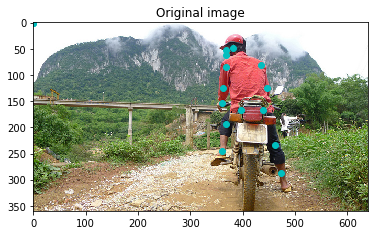

In [35]:
# Original annotated image
plt.figure()
plt.title('Original image')
plt.imshow(I)
plt.plot(xs, ys, 'ro', color='c')

/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


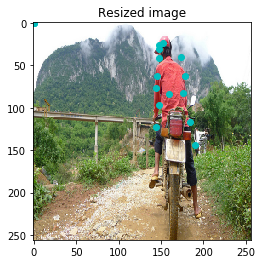

In [36]:
# Resized and annotated image
I_resized = resize(I, (256, 256))
xs_resized = xs * 256/640
ys_resized = ys * 256/512
plt.figure()
plt.title('Resized image')
plt.imshow(I_resized)
plt.plot(xs_resized, ys_resized, 'ro', color='c')

In [84]:
# Generate the heatmaps
heatmaps = heatmaps_from_keypoints(keypoints)
#print(heatmaps)
sum = np.mean(heatmaps, axis=0)

0
[[  1.00000000e+000   8.00737403e-001   4.11112291e-001 ...,
    6.84205918e-082   1.38389653e-087   1.79473628e-093]
 [  8.00737403e-001   6.41180388e-001   3.29192988e-001 ...,
    5.47869270e-082   1.10813771e-087   1.43711247e-093]
 [  4.11112291e-001   3.29192988e-001   1.69013315e-001 ...,
    2.81285462e-082   5.68936871e-088   7.37838144e-094]
 ..., 
 [  6.84205918e-082   5.47869270e-082   2.81285462e-082 ...,
    4.68137739e-163   9.46870194e-169   1.22796919e-174]
 [  1.38389653e-087   1.10813771e-087   5.68936871e-088 ...,
    9.46870194e-169   1.91516960e-174   2.48372931e-180]
 [  1.79473628e-093   1.43711247e-093   7.37838144e-094 ...,
    1.22796919e-174   2.48372931e-180   3.22107832e-186]]
1
[[  1.00000000e+000   8.00737403e-001   4.11112291e-001 ...,
    6.84205918e-082   1.38389653e-087   1.79473628e-093]
 [  8.00737403e-001   6.41180388e-001   3.29192988e-001 ...,
    5.47869270e-082   1.10813771e-087   1.43711247e-093]
 [  4.11112291e-001   3.29192988e-001   1.69

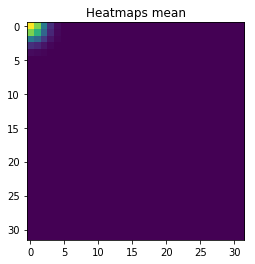

In [34]:
# Heatmaps mean
plt.figure()
plt.title('Heatmaps mean')
plt.imshow(sum)

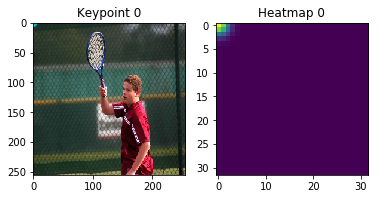

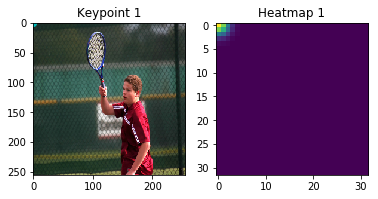

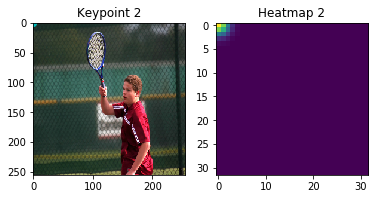

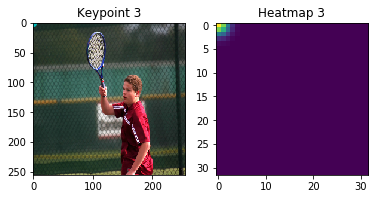

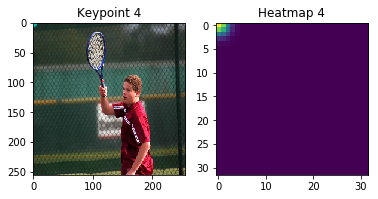

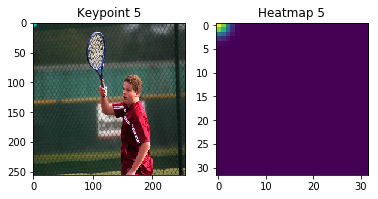

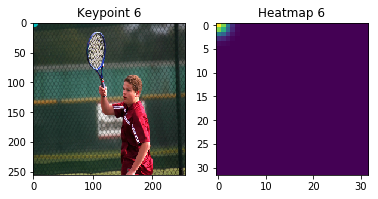

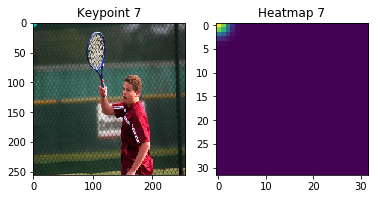

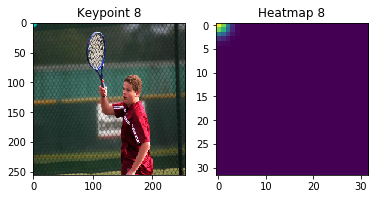

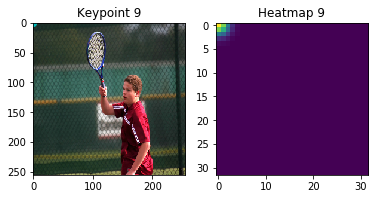

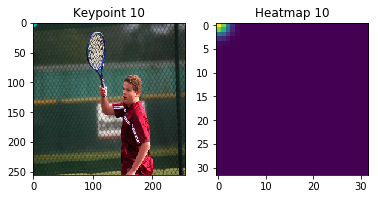

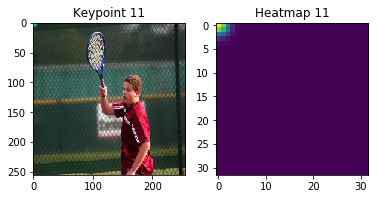

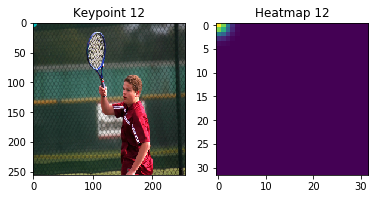

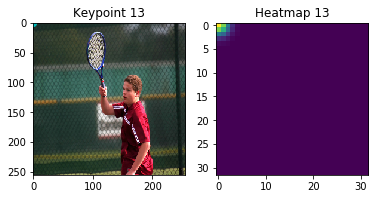

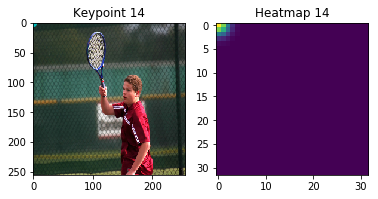

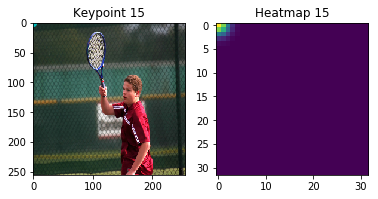

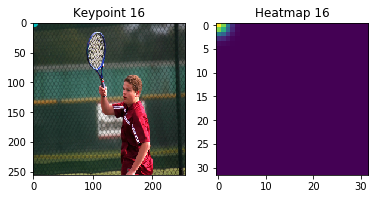

In [36]:
# Display single heatmaps with the corresponding keypoint
for i, heatmap in enumerate(heatmaps):
    
    # Create a figure for the keypoint
    plt.figure()
    
    # Display a keypoint
    plt.subplot(121)
    plt.title('Keypoint {}'.format(i))
    plt.imshow(I_resized)
    plt.plot(xs_resized[i:i+1], ys_resized[i:i+1], 'ro', color='c')
    
    # Display the corresponding heatmap
    plt.subplot(122)
    plt.title('Heatmap {}'.format(i))
    plt.imshow(I_resized)
    plt.imshow(heatmap)

## 2.2 Dataset class

### Class implementation

In [23]:
class MSCOCO(data.Dataset):
    """ Represents a MSCOCO Keypoints dataset """
    
    def __init__(self, images_folder, annotations_json, train=False, evalu=False):
        """ Instantiate a MSCOCO dataset """
        super().__init__()
        
        self.images_folder = images_folder
        
        # Load the annotations
        self.annotations = COCO(annotations_json)
        imgs_id = self.annotations.getImgIds()
        if train:
            self.img_ids = imgs_id[:50] #Not loading the whole dataset
        
        elif evalu:
            self.img_ids = imgs_id[51:76]
        
        else:
            self.img_ids = imgs_id        
    
    def __len__(self):
        return len(self.img_ids)
            
    def __getitem__(self, index):
        """ Returns the index-th image with keypoints annotations, both as tensors """
        
        # Get the image informations
        img_id = self.img_ids[index]
        img = self.annotations.loadImgs(img_id)[0]
        
        # Load the image from the file
        img_path = os.path.join(self.images_folder, img['file_name'])
        img_array = load_image(img_path)
        # Black and white images
        if len(img_array.shape)==2:
            # Add a channel axis
            img_array = np.expand_dims(img_array, axis=2)
            # Fill all the axes with the black&white image
            img_array = np.concatenate((img_array, img_array, img_array), axis=2)
        img_array = np.transpose(img_array, (2,1,0))
        
        # Get the keypoints
        annIds = self.annotations.getAnnIds(imgIds=img['id'])
        anns = self.annotations.loadAnns(annIds)
        # Some images do not contain any coco object, so anns = []
        if len(anns)>0:
            keypoints = anns[0]['keypoints'] # anns is a list with only one element
        else:
            # keypoints are not visible so 
            keypoints = [0 for i in range(3*17)]
            
        # Check to avoid errors
        if len(keypoints)!=3*17:
            print('Warning: Keypoints list for image {} has length {} instead of 17'.format(img_id, len(keypoints)))
    
        # Generate the heatmaps
        heatmaps_array = heatmaps_from_keypoints(keypoints)
        
        # Transform arrays into tensors
        img_tensor = torch.from_numpy(img_array)
        img_tensor = img_tensor.float() # Pytorch needs a float tensor
        keypoints_tensor = torch.from_numpy(heatmaps_array).float() # Pytorch needs a float tensor
        
        return img_tensor, keypoints_tensor

### Example

In [19]:
dataset = MSCOCO(IMAGES_FOLDER, ANNOTATION_FILE)
print('Dataset length: {}'.format(len(dataset)))
img_tensor, keypoints_tensor = dataset[0]
print('Image tensor:{}\n'.format(img_tensor))
print('Keypoints tensor:{}\n'.format(keypoints_tensor))

loading annotations into memory...
Done (t=12.98s)
creating index...
index created!
Dataset length: 25


/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Image tensor:
( 0 ,.,.) = 
  0.3062  0.3055  0.2838  ...   0.6554  0.6275  0.6244
  0.2914  0.2714  0.3121  ...   0.6286  0.7268  0.6850
  0.2736  0.3266  0.3121  ...   0.7334  0.6840  0.7189
           ...             ⋱             ...          
  0.0768  0.2668  0.1086  ...   0.5522  0.4313  0.3971
  0.1785  0.2094  0.1964  ...   0.5634  0.4394  0.3254
  0.5084  0.6143  0.4102  ...   0.5427  0.5524  0.4462

( 1 ,.,.) = 
  0.4649  0.4493  0.4144  ...   0.6686  0.6217  0.6204
  0.4278  0.4296  0.4629  ...   0.6294  0.7257  0.6771
  0.4079  0.4629  0.4551  ...   0.6885  0.6540  0.7140
           ...             ⋱             ...          
  0.0888  0.3922  0.1468  ...   0.5568  0.4236  0.3969
  0.1663  0.2548  0.2876  ...   0.5762  0.4395  0.3195
  0.6733  0.7034  0.5117  ...   0.5462  0.5506  0.3051

( 2 ,.,.) = 
  0.2212  0.1974  0.1717  ...   0.6701  0.6358  0.6433
  0.1926  0.1720  0.2048  ...   0.6579  0.7549  0.6923
  0.1788  0.2128  0.1815  ...   0.6958  0.6931  0.7326
          

In [20]:
print('Dataset length: {}'.format(len(trainset)))
img_tensor, keypoints_tensor = trainset[0]
print('Image tensor:{}\n'.format(img_tensor))
print('Keypoints tensor:{}\n'.format(keypoints_tensor))

Dataset length: 78858


/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Image tensor:
( 0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.5496  0.5729  0.7335
  1.0000  1.0000  1.0000  ...   0.7590  0.7356  0.7972
  1.0000  1.0000  1.0000  ...   0.6945  0.7927  0.7960
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   0.2806  0.2620  0.2058
  1.0000  1.0000  1.0000  ...   0.2877  0.3359  0.2568
  1.0000  1.0000  1.0000  ...   0.2260  0.2316  0.2325

( 1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.4022  0.4181  0.6435
  1.0000  1.0000  1.0000  ...   0.6575  0.6185  0.6915
  1.0000  1.0000  1.0000  ...   0.6132  0.6950  0.6843
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   0.3026  0.3238  0.2653
  1.0000  1.0000  1.0000  ...   0.2957  0.3554  0.3379
  1.0000  1.0000  1.0000  ...   0.2520  0.2661  0.3018

( 2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.3051  0.3402  0.4723
  1.0000  1.0000  1.0000  ...   0.4839  0.4450  0.4812
  1.0000  1.0000  1.0000  ...   0.4554  0.4924  0.4857
          

# 3. Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.model_zoo as model_zoo
from torch.nn import init

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, training=True, padding=1, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,
                            out_channels,
                            kernel_size,
                            padding=padding,
                            stride=stride)

        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.training = training

    def forward(self, x):
        x = self.relu(self.conv(x))
        if self.training:
            x = self.batch_norm(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

        self.feature_extraction = nn.Sequential(
                ConvRelu(3, 64, 3),
                ConvRelu(64, 64, 3),
                self.pool,
                ConvRelu(64, 128, 3),
                ConvRelu(128, 128, 3),
                self.pool,
                ConvRelu(128, 128, 3),
                ConvRelu(128, 128, 3),
                self.pool,
                ConvRelu(128, 512, 3),
                ConvRelu(512, 512, 3),
                )
        
        self.features_to_heatmaps = nn.Conv2d(512, 17, 1) # 17 kind of joints, 17 heatmaps

    def forward(self, x):
        x = self.feature_extraction(x)
        heatmaps = self.features_to_heatmaps(x)
        return heatmaps

#### Forward pass example on the dataset

In [35]:
def plotKeypointsOverOutputModel(index,dataset,model,img_folder):
    """Forward a img to the model and display the output keypoints over the image.
       It enables us to see the loss evolution over the model visually over the image
       index is the index of the img in the dataset argument"""
    # Get an image
    imgId = dataset.img_ids[index]
    img, keypoints = dataset[index]

    # Transform into a pytorch model input and Forward pass 
    y = model(Variable(img.unsqueeze(0)))

    #Get the coordinates of the keypoints
    keypoints = keypoints_from_heatmaps(y[0].data.numpy())

    # Plot the image
    img_anno = dataset.annotations.loadImgs(imgId)[0]
    img_path = os.path.join(img_folder, img_anno['file_name'])
    img_array = load_image(img_path)
    img_array_resized = resize(img_array, (512, 640))
    plt.figure()
    plt.title('Original image')
    plt.imshow(img_array_resized)
    xs,ys,vs = get_xs_ys_vs(keypoints)
    plt.plot(xs,ys,'ro',color='c')
    plt.show()



# Training

In [21]:
# Clean the memory
del(net)
del(trainset)
del(imgIds)
del(coco)

NameError: name 'imgIds' is not defined

In [3]:
import pickle
a = {'loss_training':[1,2,3],'loss_val':[1,4]}
fileObject = open('/Users/alexandresioufi/Desktop/loss_test','ab')
pickle.dump(a,fileObject)
fileObject.close()

In [10]:
fileObject = open('/Users/alexandresioufi/Desktop/loss_test','rb')  
b = pickle.load(fileObject)
b['loss_training'].append(4)

UnsupportedOperation: write

In [16]:
A = os.path.join(MAIN_FOLDER,"loss_"+"3")
A

'/Volumes/TOSHIBA EXT/data/loss_3'

#### Configuration

In [13]:
def conf_training(resuming=False, *args):
    """Function that initiates the configuration of the model depending if a last model
       is loaded or if it's the beginning of a new model"""
    
    #Data
    trainset = MSCOCO(IMAGES_FOLDER, ANNOTATION_FILE, train=True)
    evalset = MSCOCO(IMAGES_FOLDER, ANNOTATION_FILE, evalu=True)

    # Loss
    criterion = nn.MSELoss()
    
    # Number of epochs
    epochs = 10

    # Batch sizes
    batch_size_train = 1
    batch_size_val = 1
    
    if not resuming:
        # Model
        net = Model()

        # Optimizer
        optimizer = torch.optim.Adam(net.parameters())
        
        #First epoch
        current_epoch = 0
        
        #Loss train and val setup
        loss_train = []
        loss_val = []
    
    else:
        #Load the last saved model with its configurations
        checkpoint = torch.load(os.path.join(MAIN_FOLDER,"model_"+args[0])) #Take the last file - Later the best saved model
        
        #Model
        net = Model()
        net.load_state_dict(checkpoint['state_dict'])
        
        #Current_epoch
        current_epoch = checkpoint['epoch']
        
        #Optimizer
        #optimizer = load_state_dict(checkpoint['optimizer'])
        optimizer = torch.optim.Adam(net.parameters())
        
        #Loss train and val history
        lossObject = open(os.path.join(MAIN_FOLDER,"loss_" + args[0]),'rb')  
        loss_dic = pickle.load(lossObject)
        loss_train = loss_dic['loss_train']
        loss_val = loss_dic['loss_val']
    
    #Data loaders
    trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=batch_size_train,
                                         shuffle=True,
                                         num_workers=4
                                        )

    evaloader = torch.utils.data.DataLoader(evalset,
                                         batch_size=batch_size_val,
                                         shuffle=True,
                                         num_workers=4
                                        )
    
    evalset_length = len(evalset)
    
    return epochs, trainloader, evaloader, optimizer, net, current_epoch, loss_train, loss_val, criterion, evalset_length, evalset

#### Training procedure

In [14]:
# TODO :
#  - logs
#  - loading bar

def training(epochs, trainloader, evaloader, optimizer, net, current_epoch, loss_train, loss_val, criterion, evalset_length, evalset):
    loss_train = loss_train
    loss_val = loss_val
    plt.ion()

    for epoch in range(current_epoch + 1, epochs):  # loop over the dataset multiple times
        print("Epoch number {}".format(epoch))
        plotKeypointsOverOutputModel(0,evalset,net,IMAGES_FOLDER)#Displaying the result over the first element of the evalset
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            print("Batch number {}".format(i))
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_train += [loss.data[0]] #Stock the loss on trainset for each mini-batches
            # print statistics
            running_loss += loss.data[0]
            """if i % 2000 == 1999:    # print every 2000 mini-batches
                print('Trainset[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0"""
            if i % 10 == 0:
                print('Trainset loss {}'.format(running_loss/10))
                running_loss = 0.0
        
        running_loss_eval = 0.0
        print("Starting Eval for Epoch {}".format(epoch))
        for i, data in enumerate(evaloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # forward 
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            running_loss_eval += loss.data[0]

        print("Evalset Loss for Epoch {0} : {1}".format(epoch,running_loss_eval/evalset_length))
        loss_val += [running_loss_eval/evalset_length] #Stock the loss on evalset for each epoch
        
        #Save the model
        state = {
            'epoch': epoch,
            'state_dict': net.state_dict()
        }
        torch.save(state, os.path.join(MAIN_FOLDER,"model_"+str(epoch))) #Save the torch model after each epoch
        
        #Save the loss
        loss_dic = {'loss_train':loss_train,'loss_val':loss_val}
        lossFile = open(os.path.join(MAIN_FOLDER, "loss_"+str(epoch)),'ab')
        pickle.dump(loss_dic,lossFile)
        lossFile.close()
        

    print('Finished Training')

def launch_training(resuming=False, *args):
    """Function that configurates the model from init or a last model ; and then it trains the model"""
    epochs, trainloader, evaloader, optimizer, net, current_epoch, loss_train, loss_val, criterion, evalset_length, evalset = conf_training(resuming, *args)
    training(epochs, trainloader, evaloader, optimizer, net, current_epoch, loss_train, loss_val, criterion, evalset_length, evalset)

loading annotations into memory...
Done (t=14.70s)
creating index...
index created!
loading annotations into memory...
Done (t=17.38s)
creating index...
index created!
Epoch number 1


/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


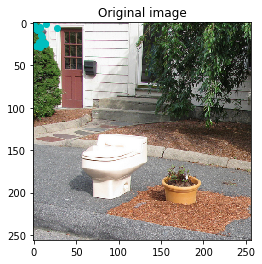

Batch number 0
Trainset loss 0.012458527833223343
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.1885403348132968
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.007879931712523103
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.0047493173042312264
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0037596019450575114
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 1
Trainset 

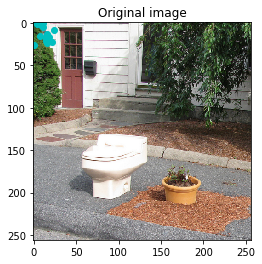

Batch number 0
Trainset loss 0.0005933342967182398
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.0029550219245720656
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.002251628472004086
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.001889082748675719
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0035691914148628713
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 2
Trains

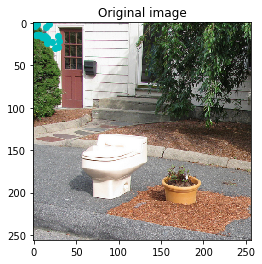

Batch number 0
Trainset loss 6.841873982921243e-05
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.001785135711543262
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.0034416458976920692
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.0021619642968289552
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.003949629690032453
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 3
Trains

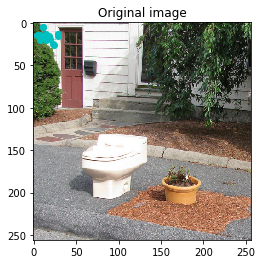

Batch number 0
Trainset loss 0.0005486775655299426
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.002178105915663764
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.0015984731260687112
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.003085039020515978
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0032929882931057365
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 4
Trains

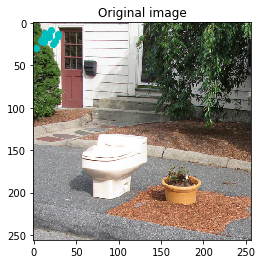

Batch number 0
Trainset loss 0.00034520227927714586
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.0029883684823289514
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.002049775171326473
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.0028317062300629915
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0016306180448736995
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 5
Trai

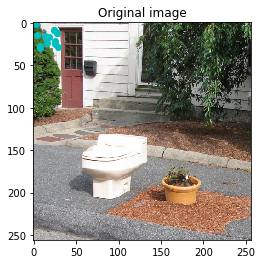

Batch number 0
Trainset loss 0.0006730537861585617
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.001854525035014376
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.0036906056775478646
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.0025255719374399632
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0020653307845350357
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 6
Train

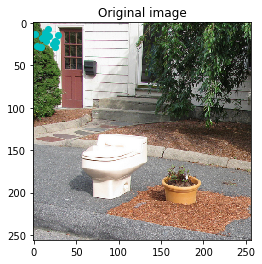

Batch number 0
Trainset loss 0.000251799076795578
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.0017602210136828944
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.0035845691163558513
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.0027733091963455083
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0018818159587681293
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 7
Train

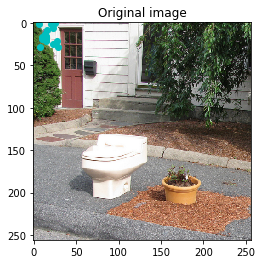

Batch number 0
Trainset loss 0.00026639874558895824
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.0030287176428828388
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.0019759069080464544
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.0025716543197631834
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.0018248843203764408
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 8
Tra

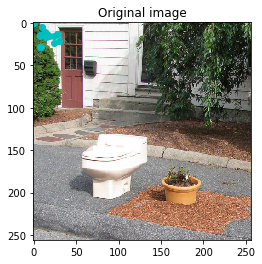

Batch number 0
Trainset loss 0.0004893808159977198
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Trainset loss 0.002470002556219697
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Batch number 19
Batch number 20
Trainset loss 0.001515993830980733
Batch number 21
Batch number 22
Batch number 23
Batch number 24
Batch number 25
Batch number 26
Batch number 27
Batch number 28
Batch number 29
Batch number 30
Trainset loss 0.002747083335998468
Batch number 31
Batch number 32
Batch number 33
Batch number 34
Batch number 35
Batch number 36
Batch number 37
Batch number 38
Batch number 39
Batch number 40
Trainset loss 0.00377328279428184
Batch number 41
Batch number 42
Batch number 43
Batch number 44
Batch number 45
Batch number 46
Batch number 47
Batch number 48
Batch number 49
Starting Eval for Epoch 9
Trainset 

In [15]:
#To launch the training from a new model
launch_training()

In [ ]:
#To resume the training from an existing model
epoch_number = 0 #Depending on which model you want to load
launch_training(resume=True, str(epoch_number))

# Test

In [ ]:
testset = MSCOCO(IMAGES_FOLDER_TEST, ANNOTATION_FILE_TEST)

#Load the training model
checkpoint = torch.load(os.path.join(MAIN_FOLDER, "0"))
net = Model()
net.load_state_dict(checkpoint['state_dict'])

# Loss
criterion = nn.MSELoss()

# Batch sizes
batch_size_test = 1

#TestLoader
evaloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size_test,
                                         shuffle=True,
                                         num_workers=4
                                        )

loss_test = 0.0
for i, data in enumerate(evaloader):
    inputs, labels = data[0], data[1]
    inputs, labels = Variable(inputs), Variable(labels)
    outputs = net(inputs)
    loss = criterion(y, outputs)
    loss_test += loss.data[0]
    if i % 500 ==0:
        print("Current loss over the test dataset: {0} after {1}ème iteration".format(loss_test/(i+1),i+1))

loss_test = loss_test/len(testset)
print("Average loss over the test dataset: {}".format(loss_test))

In [44]:
trainset = MSCOCO(IMAGES_FOLDER, ANNOTATION_FILE)

loading annotations into memory...
Done (t=87.07s)
creating index...
index created!


In [21]:
checkpoint = torch.load(os.path.join(MAIN_FOLDER, "9"))
net = Model()
net.load_state_dict(checkpoint['state_dict'])

/Users/alexandresioufi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


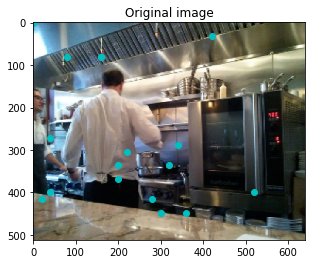

In [52]:
plotKeypointsOverOutputModel(9,trainset,net, IMAGES_FOLDER)